# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [252]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.svm import SVR
from IPython.display import Image
from sklearn.metrics import r2_score

#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold # вместо cross_val_score, который устарел

#### Подготовка данных

In [2]:
big_train_df = pd.read_csv('train.csv')
big_train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
big_train_df.shape

(1460, 81)

In [4]:
big_test_df = pd.read_csv('test.csv')
big_test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
big_test_df.shape

(1459, 80)

In [6]:
# имеем 2 близких по размеру массива данных. Для обработки категориальных фичей сольем их в один. Шкалирование будем делать отдельно
# предварительно создадим поле 'is_test', чтобы их потом правильно разделить
big_train_df['is_test'] = 0
big_test_df['is_test'] = 1

In [7]:
full_df = pd.concat([big_train_df, big_test_df], axis=0, sort = False)

pd.options.display.max_rows = 90
full_df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


In [8]:
# посмотрим на типы значений в столбцах и проверим на пропущенные
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

In [9]:
full_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,is_test
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890,0.499829
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883,0.500086
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000,0.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,0.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,1.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,1.000000


In [10]:
# оценим количество остутствующих значений
full_df.isna().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [11]:
# только те, где их больше ноля
full_df.isna().sum()[full_df.isna().sum()>0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

In [12]:
incomplete_cols = list(full_df.columns[full_df.isna().sum()>0])
print(incomplete_cols)

['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SalePrice']


In [13]:
# 'SalePrice' убираем
del incomplete_cols[-1]
print(incomplete_cols)

['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [14]:
# разделим эти признаки на числовые и категориальные, т.к. с ними поступать будем по-разному
incomplete_num_cols =[c for c in incomplete_cols 
                    if full_df[c].dtype.name != 'object' and c not in ['Id','SalePrice']] # 'Id' и 'SalePrice' не учитываем
incomplete_num_cols

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [15]:
incomplete_cat_cols = [c for c in incomplete_cols if full_df[c].dtype.name == 'object']
incomplete_cat_cols

['MSZoning',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [16]:
# простая проверка
len(incomplete_num_cols) + len(incomplete_cat_cols) == len(incomplete_cols)

True

In [17]:
set(incomplete_num_cols) | set(incomplete_cat_cols) == set(incomplete_cols)

True

In [18]:
# заменим пропущенные значения в incomplete_num_cols на нули, т.к. отсутствие гаража это ноль гаражей

In [19]:
full_df[incomplete_num_cols] = full_df[incomplete_num_cols].fillna(0)

In [20]:
# заменим пропущенные значения в incomplete_cat_cols на строку 'empty', т.к. отсутствие гаража это ноль гаражей

In [21]:
full_df[incomplete_cat_cols] = full_df[incomplete_cat_cols].fillna('empty')

In [22]:
# проверим результат
full_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,is_test
0,1,60,RL,65.0,8450,Pave,empty,Reg,Lvl,AllPub,...,empty,empty,empty,0,2,2008,WD,Normal,208500.0,0
1,2,20,RL,80.0,9600,Pave,empty,Reg,Lvl,AllPub,...,empty,empty,empty,0,5,2007,WD,Normal,181500.0,0
2,3,60,RL,68.0,11250,Pave,empty,IR1,Lvl,AllPub,...,empty,empty,empty,0,9,2008,WD,Normal,223500.0,0
3,4,70,RL,60.0,9550,Pave,empty,IR1,Lvl,AllPub,...,empty,empty,empty,0,2,2006,WD,Abnorml,140000.0,0
4,5,60,RL,84.0,14260,Pave,empty,IR1,Lvl,AllPub,...,empty,empty,empty,0,12,2008,WD,Normal,250000.0,0


In [23]:
# в incomplete_cat_cols не попали несколько колонок, т.к. в переменную incomplete_cat_cols присвоили только категориальные фичи, в которых
# были пропущены значения. А вот про 'Street', 'Alley' и другие категориальные фичи забыли.
# переопределим incomplete_cat_cols:
incomplete_cat_cols = [c for c in full_df if full_df[c].dtype.name == 'object']
print(incomplete_cat_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [24]:
# для incomplete_cat_cols сделаем get_dummies
full_df_encoded = pd.get_dummies(full_df, columns=incomplete_cat_cols)
full_df_encoded.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_empty,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,1,0,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,1,0,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,1,0,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,1,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,1,0,0,0,0,0,1,0


In [25]:
incomplete_cat_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [170]:
# получили 314 колонок
print(list(full_df_encoded.columns))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'is_test', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'MSZoning_empty', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave', 'Alley_empty', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'Utilities_empty', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Lan

In [26]:
full_df_encoded.shape

(2919, 314)

In [27]:
# будем считать, что подготовили датафрейм для скармливания модели

# разделим обратно на big_test_df и big_train_df
big_train_df = full_df_encoded[full_df_encoded['is_test']==0]
big_test_df = full_df_encoded[full_df_encoded['is_test']==1]

In [28]:
# избавляемся от ненужной колонки 'is_test'
big_train_df = big_train_df.drop(columns = ['is_test'] , axis=1)
big_test_df = big_test_df.drop(columns = ['is_test'] , axis=1)

In [29]:
X = big_train_df.drop(columns = ['SalePrice'] , axis=1)
y = big_train_df['SalePrice']
X_postponed = big_test_df

In [30]:
# получилось, что в X столбцов на 1 меньше, чем в X_postponed, что не есть хорошо
print(y.shape)
print(X.shape)
print(X_postponed.shape)

(1460,)
(1460, 312)
(1459, 313)


In [31]:
# найдем "прилепившийся" к отложенной выборке столбец
set(X.columns) ^ set(X_postponed.columns)

{'SalePrice'}

In [32]:
# столбец 'SalePrice' остался после слияния big_train_df и big_test_df
X_postponed['SalePrice'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: SalePrice, dtype: float64

In [33]:
# удалим его 
X_postponed = X_postponed.drop(columns = ['SalePrice'] , axis=1)

In [34]:
# теперь все в порядке
print(y.shape)
print(X.shape)
print(X_postponed.shape)

(1460,)
(1460, 312)
(1459, 312)


#### Используем 10-fold кросс-валидацию для оценки качества моделей

In [35]:
# шкалировать пока ничего не будем, т.к. для деревьев нормированные данные не требуются
kf = KFold(n_splits=10, shuffle=True, random_state=42)


In [36]:
# в качестве классификатора берем дерево
clf = DecisionTreeClassifier()

In [37]:
# у нас 10 фолдов
kf.get_n_splits(X)

10

In [38]:
# разбиваем данные на 10 частей и выводим индексы
for k in enumerate(kf.split(X)):
    print(k)
    break

(0, (array([   0,    1,    2, ..., 1457, 1458, 1459]), array([  15,   29,   43,   44,   49,   51,   59,   65,   67,   70,   76,
         78,  101,  115,  123,  141,  168,  175,  184,  192,  198,  203,
        218,  220,  231,  244,  259,  270,  274,  275,  277,  316,  322,
        332,  351,  363,  374,  382,  394,  398,  411,  413,  415,  416,
        422,  427,  429,  433,  453,  464,  490,  494,  522,  526,  532,
        543,  554,  567,  576,  581,  584,  585,  589,  590,  591,  614,
        619,  628,  636,  643,  649,  670,  674,  679,  682,  691,  718,
        720,  736,  746,  754,  765,  772,  788,  811,  836,  838,  846,
        855,  887,  892,  894,  898,  906,  916,  922,  925,  990,  994,
       1006, 1024, 1032, 1033, 1036, 1040, 1047, 1061, 1078, 1092, 1094,
       1101, 1102, 1105, 1108, 1113, 1120, 1131, 1132, 1134, 1138, 1160,
       1164, 1173, 1201, 1216, 1220, 1221, 1228, 1240, 1249, 1252, 1265,
       1269, 1272, 1293, 1299, 1317, 1320, 1340, 1344, 1347, 1392, 13

In [39]:
# индексы из первого фолда
first_fold = list(kf.split(X, y))[0][1].tolist()
print(first_fold)

[15, 29, 43, 44, 49, 51, 59, 65, 67, 70, 76, 78, 101, 115, 123, 141, 168, 175, 184, 192, 198, 203, 218, 220, 231, 244, 259, 270, 274, 275, 277, 316, 322, 332, 351, 363, 374, 382, 394, 398, 411, 413, 415, 416, 422, 427, 429, 433, 453, 464, 490, 494, 522, 526, 532, 543, 554, 567, 576, 581, 584, 585, 589, 590, 591, 614, 619, 628, 636, 643, 649, 670, 674, 679, 682, 691, 718, 720, 736, 746, 754, 765, 772, 788, 811, 836, 838, 846, 855, 887, 892, 894, 898, 906, 916, 922, 925, 990, 994, 1006, 1024, 1032, 1033, 1036, 1040, 1047, 1061, 1078, 1092, 1094, 1101, 1102, 1105, 1108, 1113, 1120, 1131, 1132, 1134, 1138, 1160, 1164, 1173, 1201, 1216, 1220, 1221, 1228, 1240, 1249, 1252, 1265, 1269, 1272, 1293, 1299, 1317, 1320, 1340, 1344, 1347, 1392, 1397, 1398, 1414, 1428]


In [40]:
# выведем первый фолд для примера
X[X.index.isin(first_fold)].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_empty,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
15,16,45,51.0,6120,7,8,1929,2001,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
29,30,30,60.0,6324,4,6,1927,1950,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
43,44,20,0.0,9200,5,6,1975,1980,0.0,280.0,...,0,0,1,0,0,0,0,0,1,0
44,45,20,70.0,7945,5,6,1959,1959,0.0,179.0,...,0,0,1,0,0,0,0,0,1,0
49,50,20,66.0,7742,5,7,1966,1966,0.0,763.0,...,0,0,1,0,0,0,0,0,1,0


In [41]:
# соберем индексы каждого из 10 фолдов в список списков
indexes_for_kfold = []
for i in range(0, kf.get_n_splits(X) ):
    current_fold = list(kf.split(X))[i][1].tolist()
    indexes_for_kfold.append(current_fold)
    print(current_fold)

[15, 29, 43, 44, 49, 51, 59, 65, 67, 70, 76, 78, 101, 115, 123, 141, 168, 175, 184, 192, 198, 203, 218, 220, 231, 244, 259, 270, 274, 275, 277, 316, 322, 332, 351, 363, 374, 382, 394, 398, 411, 413, 415, 416, 422, 427, 429, 433, 453, 464, 490, 494, 522, 526, 532, 543, 554, 567, 576, 581, 584, 585, 589, 590, 591, 614, 619, 628, 636, 643, 649, 670, 674, 679, 682, 691, 718, 720, 736, 746, 754, 765, 772, 788, 811, 836, 838, 846, 855, 887, 892, 894, 898, 906, 916, 922, 925, 990, 994, 1006, 1024, 1032, 1033, 1036, 1040, 1047, 1061, 1078, 1092, 1094, 1101, 1102, 1105, 1108, 1113, 1120, 1131, 1132, 1134, 1138, 1160, 1164, 1173, 1201, 1216, 1220, 1221, 1228, 1240, 1249, 1252, 1265, 1269, 1272, 1293, 1299, 1317, 1320, 1340, 1344, 1347, 1392, 1397, 1398, 1414, 1428]
[23, 30, 32, 56, 58, 63, 81, 99, 107, 111, 128, 163, 196, 208, 233, 237, 239, 240, 247, 261, 271, 289, 297, 306, 309, 310, 324, 339, 344, 350, 353, 354, 358, 361, 365, 367, 371, 423, 425, 426, 428, 432, 451, 478, 479, 528, 529, 535, 5

In [42]:
def custom_kfold_r2s(X, y, kfold_with_params, classifier, prin=True, retur = True):
    """Функция делит данные на фолды, сохраняет индексы строк каждого фолда в список, обучает классификатор,
    запоминает его результат r2_score в словарь и выводит результат по каждому фолду и среднее значение r2_score
    """
    #from sklearn.metrics import accuracy_score
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score
    
    indexes_for_kfold = []
    for i in range(0, kf.get_n_splits(X) ):
        indexes = list(kf.split(X))[i][1].tolist()
        indexes_for_kfold.append(indexes)
    
    r2s_dict = {}
    predictions = []
    fold_number = 1

    for indexes in indexes_for_kfold:
        X_test = X[X.index.isin(indexes)]
        y_test = y[y.index.isin(indexes)]
        X_train = X[X.index.isin(list(set(X.index) - set(indexes)))]
        y_train = y[y.index.isin(list(set(y.index) - set(indexes)))]
        
        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        predictions.append(prediction)
        r2s = r2_score(y_test, prediction)
        
        r2s_dict[fold_number] = r2s
        fold_number += 1
    
    if retur:
        return predictions
    if prin:
        print('Коэффициент детерминации (Coefficient of determination) - Данный показатель является\
        статистической мерой согласия, с помощью которой можно определить,\
        насколько уравнение регрессии соответствует реальным данным.')
        print()
        for key in r2s_dict.keys():
            print('Фолд номер {0} дал Coefficient of determination {1:.3f}'.format(key, r2s_dict[key]))
        print('--------------------')
        print('Средняя r2s: {0:.3f}'.format( np.mean(list(r2s_dict.values() )  ) ) )


In [43]:
custom_kfold_r2s(X, y, kf, clf, prin = True, retur = False)

Коэффициент детерминации (Coefficient of determination) - Данный показатель является        статистической мерой согласия, с помощью которой можно определить,        насколько уравнение регрессии соответствует реальным данным.

Фолд номер 1 дал Coefficient of determination 0.528
Фолд номер 2 дал Coefficient of determination 0.682
Фолд номер 3 дал Coefficient of determination 0.564
Фолд номер 4 дал Coefficient of determination 0.263
Фолд номер 5 дал Coefficient of determination 0.349
Фолд номер 6 дал Coefficient of determination 0.670
Фолд номер 7 дал Coefficient of determination 0.494
Фолд номер 8 дал Coefficient of determination 0.546
Фолд номер 9 дал Coefficient of determination 0.448
Фолд номер 10 дал Coefficient of determination 0.382
--------------------
Средняя r2s: 0.493


In [44]:
custom_kfold_r2s(X, y, kf, clf, prin = False, retur = True)

[array([101000.,  86000., 112500., 126175., 129500., 140000., 129500.,
        274300., 212000., 190000., 119000., 137500., 196500., 168500.,
        167240., 372402., 195000., 143000., 100000., 179900., 103200.,
        144000., 108959., 178000., 410000., 193000.,  97500., 244600.,
        133500., 177000., 133700., 169500., 320000., 200000., 239686.,
         85400., 214900., 236000., 108000., 154000., 132500., 119000.,
        188000., 122500., 156000., 128900., 164000., 176500., 197000.,
        157000., 147000., 115000., 197500.,  97500., 127500., 140000.,
        233000., 179200., 177000., 372500., 140200., 274900., 115000.,
        154000., 426000.,  92000., 223500., 169900.,  82000., 103600.,
         81000., 168000., 157000., 130000., 143000., 290000., 290000.,
        275000.,  90000., 230000., 109900., 202900., 153000., 100000.,
        141000., 140000., 134450., 162000., 130000., 174500., 145500.,
        118964., 274900., 262000.,  86000., 176432., 171000., 340000.,
      

#### Построить случайный лес, вывести важность признаков


In [45]:
clf = RandomForestRegressor()

In [46]:
clf.fit(X,y)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [47]:
# целевая переменная сильно зависит только от OverallQual (состояние) 

feature_sign = pd.DataFrame(X.columns, columns=['feature'])
feature_sign['significance'] = clf.feature_importances_

feature_sign.sort_values(by='significance', ascending=False).head(10)

,feature,significance
4,OverallQual,0.595106
16,GrLivArea,0.091435
26,GarageCars,0.032245
12,TotalBsmtSF,0.031382
9,BsmtFinSF1,0.027962
14,2ndFlrSF,0.026553
13,1stFlrSF,0.021806
27,GarageArea,0.014278
3,LotArea,0.014100
23,TotRmsAbvGrd,0.012877


In [48]:
# делаем предсказание
prediction = clf.predict(X_postponed)

In [51]:
prediction.shape

(1459,)

In [52]:
# создаем строки для записи в файл
submit = 'Id,SalePrice\n' # заголовки
submit += "\n".join(["{},{}".format(id, predict) for id, predict in zip(X_postponed.Id, prediction)])

In [53]:
with open('submit.csv', 'w') as file:
    file.write(submit)

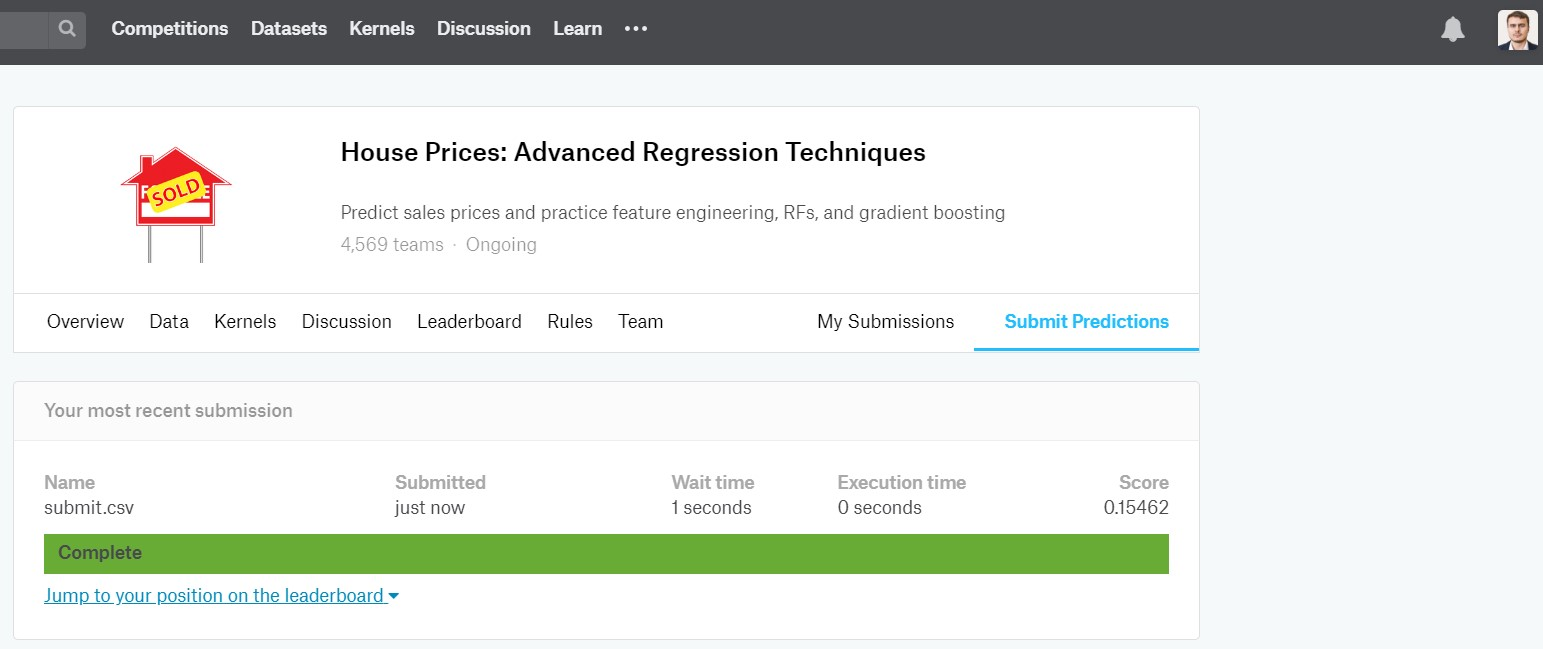

In [54]:
Image("Screenshot_2.jpg")

In [55]:
# Root Mean Squared Logarithmic Error на Kaggle 0.15462

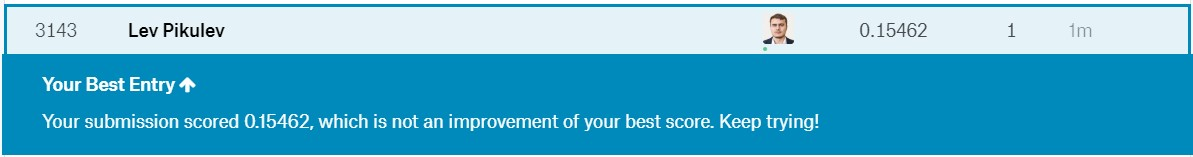

In [56]:
Image("Screenshot_3.jpg")

#### Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

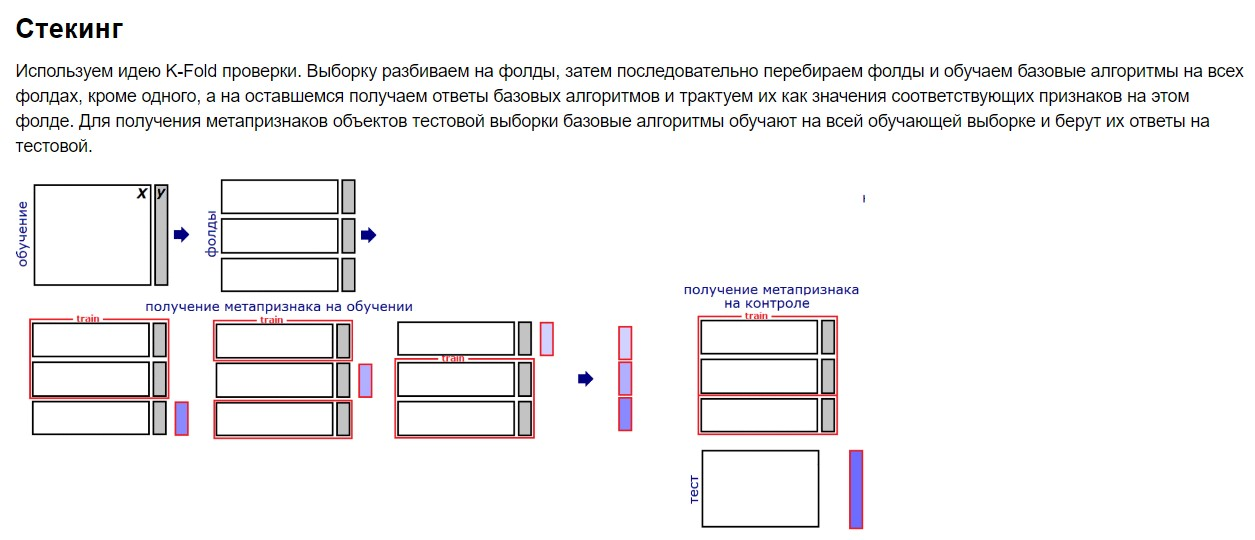

In [6]:
Image("Screenshot_1.jpg")

In [68]:
# необходимо шкалировать данные для регрессоров
# определим колонки, для которых нужно сделать StandartScaler
original_num_columns = [c for c in full_df.columns if full_df[c].dtype.name != 'object' and c not in ['Id','SalePrice', 'is_test']]

In [152]:
columns_for_scal = list(set(original_num_columns) & set(X.columns))
columns_for_scal

['KitchenAbvGr',
 'HalfBath',
 'BsmtHalfBath',
 'MiscVal',
 'TotRmsAbvGrd',
 '1stFlrSF',
 'MoSold',
 'GarageCars',
 '2ndFlrSF',
 'GrLivArea',
 'OpenPorchSF',
 'FullBath',
 'MSSubClass',
 'LowQualFinSF',
 'OverallQual',
 '3SsnPorch',
 'PoolArea',
 'YearBuilt',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'LotArea',
 'BsmtUnfSF',
 'ScreenPorch',
 'GarageYrBlt',
 'LotFrontage',
 'WoodDeckSF',
 'BedroomAbvGr',
 'EnclosedPorch',
 'BsmtFullBath',
 'TotalBsmtSF',
 'Fireplaces',
 'GarageArea',
 'YrSold',
 'MasVnrArea',
 'YearRemodAdd',
 'OverallCond']

In [71]:
# правильнее будет применять скалер к каждому фолду отдельно
scaler = StandardScaler()

In [72]:
# пока делим наши X и y на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [76]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 312)
(292, 312)
(1168,)
(292,)


In [84]:
# выбираем модели
models = [RandomForestRegressor(), LogisticRegression(), SVR(kernel='poly')]

In [85]:
# создаем 3 фолда
kf = KFold(n_splits=3, random_state=42)

In [97]:
# посмотрим на индексы каждого из 3 фолдов
indexes_for_kf = []
for i in range(len(list(kf.split(X_train)))):
    fold = list(kf.split(X_train))[i][1]
    print(fold)
    indexes_for_kf.append(fold)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [141]:
# все, кроме последнего фолда соединяем в один для обучения
big_fold = []
for i in range(len(indexes_for_kf)-1):
    big_fold += list(indexes_for_kf[i])
#последний фолд пока не будем использовать 
small_fold = indexes_for_kf[-1]

In [143]:
#создаем датафреймы для обучения моделей
X_train = X[X.index.isin( big_fold )]
y_train = y[y.index.isin( big_fold )]

In [147]:
# пропущенных значений нет
X_train.isna().sum()[X_train.isna().sum()>0]

Series([], dtype: int64)

In [148]:
y_train.isna().sum()[y_train.isna().sum()>0]

array([], dtype=int64)

In [156]:
#шкалируем нужные столбцы
# import...
scaler = StandardScaler()
scaler.fit(X_train[columns_for_scal])
X_train.loc[:, columns_for_scal] = pd.DataFrame(scaler.transform(X_train[columns_for_scal]), columns=columns_for_scal)
X_train.head()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_empty,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,0.060354,0.214381,-0.193052,0.600569,-0.512374,1.037477,0.853525,0.430796,0.564355,...,0,0,1,0,0,0,0,0,1,0
1,2,-0.870657,0.675376,-0.102278,-0.115883,2.172421,0.145503,-0.482104,-0.588460,1.170398,...,0,0,1,0,0,0,0,0,1,0
2,3,0.060354,0.306580,0.027963,0.600569,-0.512374,0.971405,0.804057,0.253986,0.074174,...,0,0,1,0,0,0,0,0,1,0
3,4,0.293107,0.060716,-0.106225,0.600569,-0.512374,-1.869698,-0.778910,-0.588460,-0.527413,...,0,0,1,0,1,0,0,0,0,0
4,5,0.060354,0.798308,0.265555,1.317021,-0.512374,0.938369,0.705122,1.231639,0.450722,...,0,0,1,0,0,0,0,0,1,0


In [159]:
# обучаем модели
learned_models = []
meta_X_train = [] # результаты предсказаний моделей кладем в список
for model in models:
    model.fit(X_train, y_train)
    learned_models.append(model) # сохраняем в список обученные модели
    scaler = StandardScaler() #шкалируем X
    scaler.fit(X_train[columns_for_scal])
    X.loc[:, columns_for_scal] = pd.DataFrame(scaler.transform(X[columns_for_scal]), columns=columns_for_scal)
    meta_X_train.append(model.predict(X) ) # делаем предсказание на полном X
    print('Model {0} DONE'.format(model))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [170]:
meta_X_train

[array([541701.9, 432420. , 541701.9, ..., 565488.5, 444637.4, 458970. ]),
 array([375000., 375000., 375000., ..., 375000., 375000., 375000.]),
 array([1.48615585e+08, 2.19006867e+08, 3.30383530e+08, ...,
        1.92213796e+09, 2.19530637e+09, 2.33888552e+09])]

In [168]:
np.array(meta_X_train).T

array([[5.41701900e+05, 3.75000000e+05, 1.48615585e+08],
       [4.32420000e+05, 3.75000000e+05, 2.19006867e+08],
       [5.41701900e+05, 3.75000000e+05, 3.30383530e+08],
       ...,
       [5.65488500e+05, 3.75000000e+05, 1.92213796e+09],
       [4.44637400e+05, 3.75000000e+05, 2.19530637e+09],
       [4.58970000e+05, 3.75000000e+05, 2.33888552e+09]])

In [171]:
# создаем массив для обучения метаалгоритма
meta_X_train = np.array(meta_X_train).T

In [174]:
print(meta_X_train.shape)
print(y.shape)

(1460, 3)
(1460,)


In [177]:
meta_alg = LinearRegression()

In [178]:
meta_alg.fit(meta_X_train, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

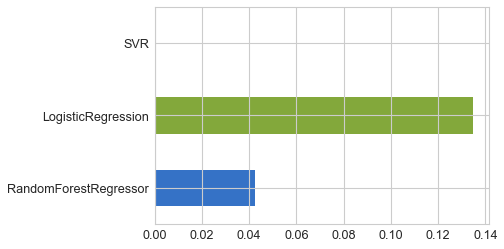

In [180]:
%matplotlib inline
pd.Series(meta_alg.coef_.flatten(), index=['RandomForestRegressor', 'LogisticRegression', 'SVR']).plot(kind='barh')

#### Обучаемся на отложенной выборке X_postponed

In [182]:
meta_X_test = []
for m in learned_models:
    prediction = m.predict(X_postponed)
    meta_X_test.append(prediction)
meta_X_test

[array([448933.7, 463451.1, 537445. , ..., 448221.1, 410135. , 537445. ]),
 array([375000., 375000., 375000., ..., 375000., 375000., 375000.]),
 array([ 2.83101476e+09, -9.67248447e+08,  4.08693816e+09, ...,
         1.74149457e+10,  5.82950520e+09,  5.78855690e+09])]

In [186]:
len(meta_X_test[2])

1459

In [187]:
meta_X_test = np.array(meta_X_test).T

In [188]:
meta_X_test

array([[ 4.48933700e+05,  3.75000000e+05,  2.83101476e+09],
       [ 4.63451100e+05,  3.75000000e+05, -9.67248447e+08],
       [ 5.37445000e+05,  3.75000000e+05,  4.08693816e+09],
       ...,
       [ 4.48221100e+05,  3.75000000e+05,  1.74149457e+10],
       [ 4.10135000e+05,  3.75000000e+05,  5.82950520e+09],
       [ 5.37445000e+05,  3.75000000e+05,  5.78855690e+09]])

In [191]:
final_pred = meta_alg.predict(meta_X_test)
final_pred

array([181953.33351502, 182193.2226654 , 185852.75339336, ...,
       183378.64011325, 180598.27752357, 186022.60003496])

In [193]:
# создаем строки для записи в файл
submit_final = 'Id,SalePrice\n' # заголовки
submit_final += "\n".join(["{},{}".format(id, predict) for id, predict in zip(X_postponed.Id, final_pred)])

with open('submit_final.csv', 'w') as file:
    file.write(submit)

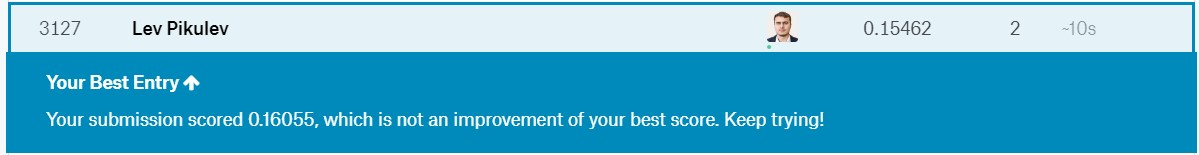

In [255]:
Image("Screenshot_4.jpg") # странно, результат ухудшился после стекинга